In [35]:
import os
#comment this if you are not using puffer?
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math

In [11]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = ''
        self.path = path
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        # self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    
        
        print("Done.")
        return self.raw
    
    
    def filter(self, freq):
        
        raw = self.raw
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        return  raw
    
    def raw_ica(self):
        raw = self.raw
        ica = mne.preprocessing.ICA(n_components=64, max_iter=100)
        ica.fit(raw)
        ica.exclude = [1, 2]  # details on how we picked these are omitted here
        ica.plot_properties(raw, picks=ica.exclude)
        ica.apply(raw)
        print('ICA DONE ????')
        return  raw
        
    def get_events(self):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')
        tmin = -1
        tmax = 4
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)
        return epochs
    
    def create_epochs(self):
        print(">>> Create Epochs.")
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        return events , event_id 
        
        print("Done.")
    
    def get_X_y(self):
        if self.epochs is None:
            events , event_id=self.create_epochs()
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        return self.X, self.y
    
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        #print(f">>> Extract all subjects from: {fullpath}.")
        extension = "edf"
        raws = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                #print(path_file)
                #print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                count += 1

        raw = mne.io.concatenate_raws(raws)
        eegbci.standardize(raw)
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
        return self.raw
        
        
        
def do_plot(train_loss, valid_loss,ty):
    if ty == "loss":
        plt.figure(figsize=(10,10))
        
        plt.plot(train_loss, label='train_loss')
        plt.plot(valid_loss, label='valid_loss')
        plt.title('loss {}'.format(iter))
        plt.legend()
        plt.show()
    if ty == "acc":
        plt.figure(figsize=(10,10))
        
        plot_ty=torch.tensor(train_loss, device = 'cpu')
        plat_va=torch.tensor(valid_loss, device = 'cpu')
        plt.plot(plot_ty, label='train_acc')
        plt.plot(plat_va, label='valid_acc')
        plt.title('acc {}'.format(iter))
        plt.legend()
        plt.show()

In [12]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = 'physionet.org/files/eegmmidb/1.0.0'
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
runs = [3, 4, 7, 8, 11, 12]
#runs = [4, 8, 12]
subjects = [i for i in range(1,80)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print(raw)
print("Raw done")
# apply filter
freq = (8., 14.)
#raw=eeg.filter(freq=freq)
#raw=eeg.data_to_raw()
print("Filter done")
#raw=eeg.raw_ica()


FileNotFoundError: [Errno 2] No such file or directory: '/home/st122148/work/EEG-Motor-Imagery-Classification/physionet.org/files/eegmmidb/1.0.0/S001/S001R03.edf'

In [ ]:
raw

In [ ]:
raw = raw.drop_channels(['FC5',
 'FC3',
 'FC1',
 'FCz',
 'FC2',
 'FC4',
 'FC6',
 'C5',
 'Cz',
 'C6',
 'CP5',
 'CP3',
 'CP1',
 'CPz',
 'CP2',
 'CP4',
 'CP6',
 'Fp1',
 'Fpz',
 'Fp2',
 'AF7',
 'AF3',
 'AFz',
 'AF4',
 'AF8',
 'F7',
 'F5',
 'F3',
 'F1',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT7',
 'FT8',
 'T7',
 'T8',
 'T9',
 'T10',
 'TP7',
 'TP8',
 'P7',
 'P5',
 'P3',
 'P1',
 'Pz',
 'P2',
 'P4',
 'P6',
 'P8',
 'PO7',
 'PO3',
 'POz',
 'PO4',
 'PO8',
 'O1',
 'Oz',
 'O2',
 'Iz',
 "C1",
 "C2"
                    ]
)


In [6]:

raw=raw.filter( 1,50, method='fir', verbose=20)


raw=raw.filter(8., 14, fir_design='firwin', verbose=20)
raw=raw.apply_hilbert()
#raw=eeg.filter(freq=freq)

NameError: name 'raw' is not defined

In [7]:
eeg.create_epochs()

NameError: name 'eeg' is not defined

In [8]:
raw.ch_names

NameError: name 'raw' is not defined

In [9]:
raw.plot_psd(fmax=50)
raw.plot(duration=5, n_channels=2)

NameError: name 'raw' is not defined

In [44]:
l_vis_T1=eeg.epochs["T1"].average()
l_vis_T2=eeg.epochs["T2"].average()

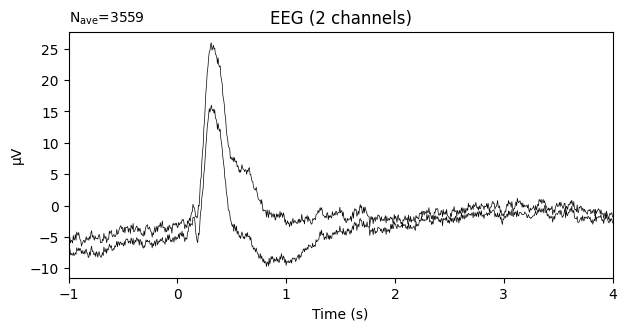

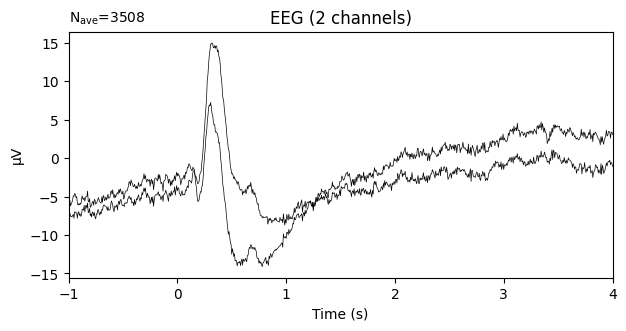

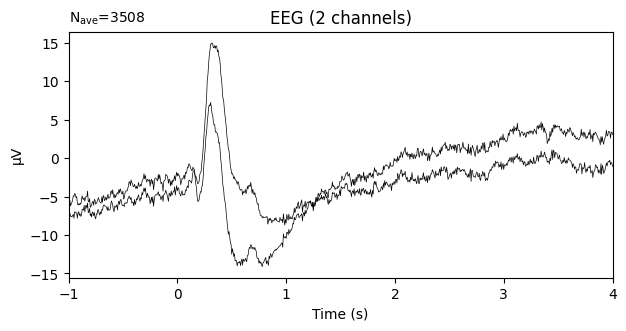

In [45]:
#l_vis_T1.plot(spatial_colors=True)
#l_vis_T2.plot(spatial_colors=True)


l_vis_T1.plot()
l_vis_T2.plot() 

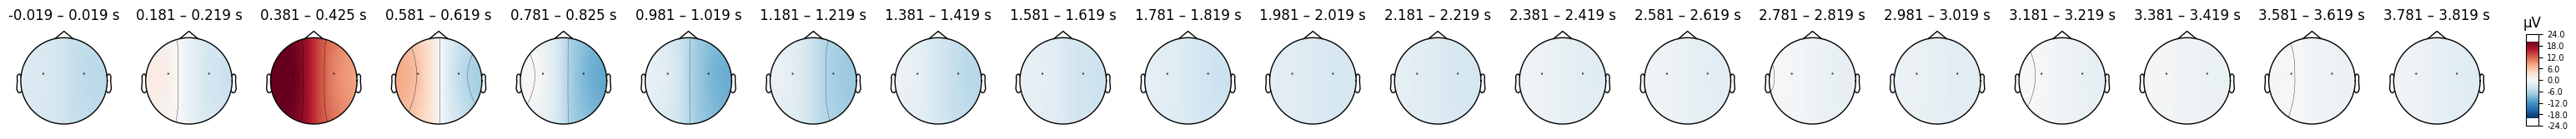

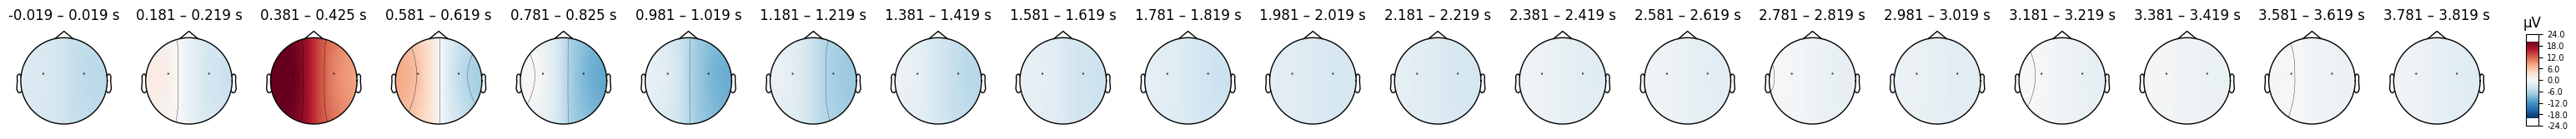

In [46]:
#left 
l_vis_T1.plot_topomap(times=list(np.arange(0, 4, 0.20)), average=0.05, ch_type="eeg")

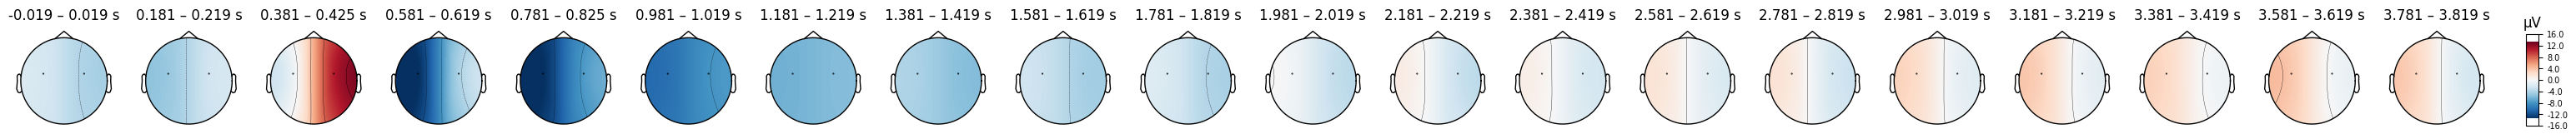

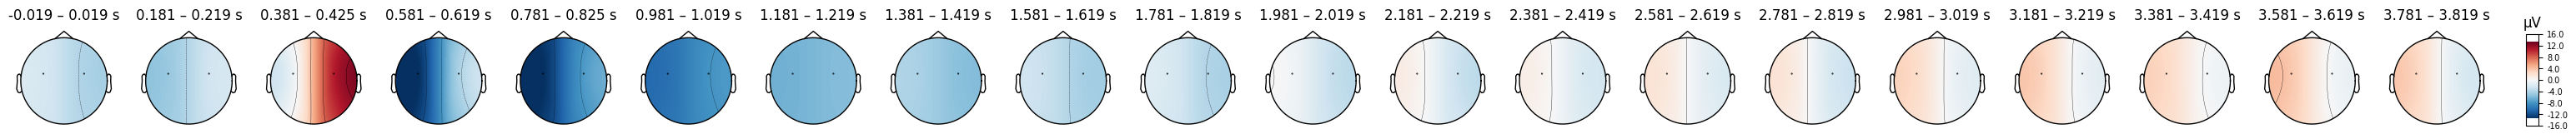

In [47]:
#right
l_vis_T2.plot_topomap(times=list(np.arange(0, 4, 0.2)), average=0.05)

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test



In [49]:

freqs = np.arange(8, 14)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1,0 )  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test
tmin, tmax = -1, 4


In [50]:
epochs = eeg.epochs
event_ids = epochs.event_id


In [51]:
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s finished


<EpochsTFR | time : [-1.000000, 4.000000], freq : [8.000000, 13.000000], epochs : 7067, channels : 2, ~259.5 MB>

In [52]:
df = tfr.to_data_frame(time_format=None)
df.head()


,time,freq,epoch,condition,C3,C4
0,-1.0000,8.0,0,T2,-0.662722,-0.737525
1,-0.9875,8.0,0,T2,-0.582607,-0.674209
2,-0.9750,8.0,0,T2,-0.498490,-0.601794
3,-0.9625,8.0,0,T2,-0.402992,-0.493294
4,-0.9500,8.0,0,T2,-0.347963,-0.402926


In [53]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

df

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


,condition,epoch,freq,time,channel,ch_type,value,band
0,T2,0,8.0,-1.0000,C3,eeg,-0.662722,alpha
1,T2,0,8.0,-1.0000,C4,eeg,-0.737525,alpha
2,T2,0,8.0,-0.9875,C3,eeg,-0.582607,alpha
3,T2,0,8.0,-0.9875,C4,eeg,-0.674209,alpha
4,T2,0,8.0,-0.9750,C3,eeg,-0.498490,alpha
...,...,...,...,...,...,...,...,...
34006399,T2,7109,13.0,3.9750,C4,eeg,-0.906793,alpha
34006400,T2,7109,13.0,3.9875,C3,eeg,-0.490309,alpha
34006401,T2,7109,13.0,3.9875,C4,eeg,-0.898256,alpha
34006402,T2,7109,13.0,4.0000,C3,eeg,-0.545630,alpha


In [54]:
# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'C4'),
                                                     ordered=True)

df

,condition,epoch,freq,time,channel,ch_type,value,band
0,T2,0,8.0,-1.0000,C3,eeg,-0.662722,alpha
1,T2,0,8.0,-1.0000,C4,eeg,-0.737525,alpha
2,T2,0,8.0,-0.9875,C3,eeg,-0.582607,alpha
3,T2,0,8.0,-0.9875,C4,eeg,-0.674209,alpha
4,T2,0,8.0,-0.9750,C3,eeg,-0.498490,alpha
...,...,...,...,...,...,...,...,...
34006399,T2,7109,13.0,3.9750,C4,eeg,-0.906793,alpha
34006400,T2,7109,13.0,3.9875,C3,eeg,-0.490309,alpha
34006401,T2,7109,13.0,3.9875,C4,eeg,-0.898256,alpha
34006402,T2,7109,13.0,4.0000,C3,eeg,-0.545630,alpha


In [58]:

g = sns.FacetGrid(df, row='band', col='condition', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'channel', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)


g.set(ylim=(None, .5))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

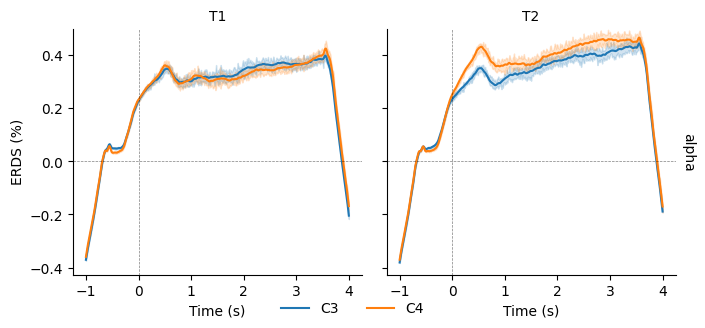

In [59]:
g.fig

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s finished


Applying baseline correction (mode: percent)
Using a threshold of 1.645282
stat_fun(H1): min=-60.966650 max=21.998429
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:04<00:00,   22.22it/s]


Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:04<00:00,   22.27it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.645282


stat_fun(H1): min=-60.966650 max=21.998429
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:04<00:00,   21.98it/s]


Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:04<00:00,   22.02it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.645282
stat_fun(H1): min=-64.598558 max=21.256662
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:04<00:00,   22.22it/s]


Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:04<00:00,   22.29it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.645282


stat_fun(H1): min=-64.598558 max=21.256662
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:04<00:00,   21.97it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:04<00:00,   22.00it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.645282
stat_fun(H1): min=-60.966650 max=21.998429
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:04<00:00,   22.13it/s]


Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:04<00:00,   22.09it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.645282


stat_fun(H1): min=-60.966650 max=21.998429
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:04<00:00,   22.22it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:04<00:00,   22.24it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied


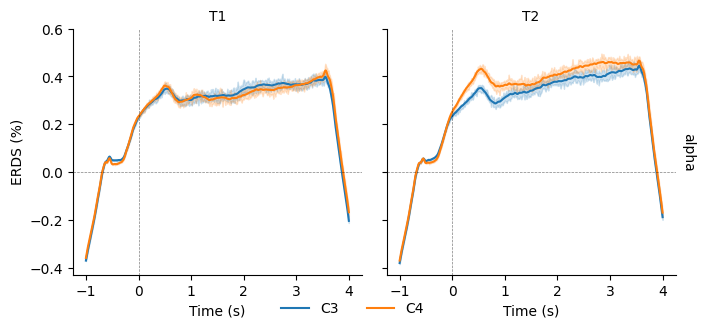

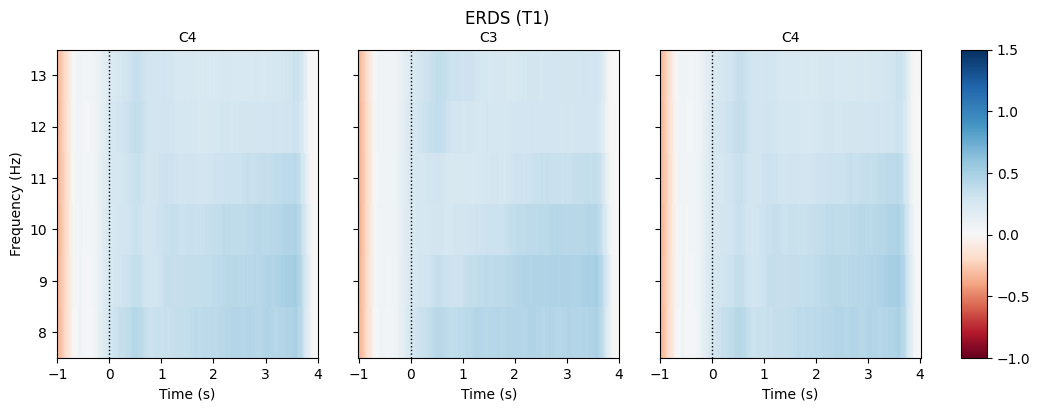

Using a threshold of 1.645288
stat_fun(H1): min=-64.687585 max=23.986895
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:04<00:00,   22.94it/s]


Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:04<00:00,   22.98it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.645288


stat_fun(H1): min=-64.687585 max=23.986895
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:04<00:00,   22.93it/s]


Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:04<00:00,   22.93it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.645288
stat_fun(H1): min=-65.075411 max=23.858715
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:04<00:00,   23.03it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:04<00:00,   23.04it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.645288
stat_fun(H1): min=-65.075411 max=23.858715
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:04<00:00,   22.96it/s]


Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:04<00:00,   22.97it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.645288
stat_fun(H1): min=-64.687585 max=23.986895
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:04<00:00,   23.00it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:04<00:00,   23.07it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.645288


stat_fun(H1): min=-64.687585 max=23.986895
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:04<00:00,   23.00it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:04<00:00,   23.00it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied


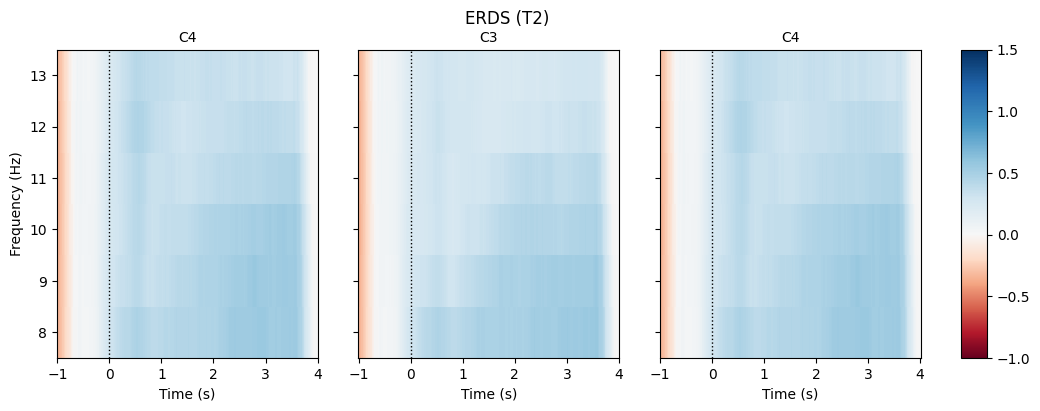

In [57]:
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch-1], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch-1], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch-1], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch-1], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    
    
    plt.show()
    
    
    
    